# Combined Mean Reversion + Momentum Strategy

This notebook combines two distinct trading strategies:
- **Mean Reversion**: 30-day lookback, active during crypto bear markets (BTC 90d return < 0)
- **Momentum**: 14-day lookback (excluding recent day), active during crypto bull markets (BTC 90d return > 0)

The strategy switches between these approaches based on market regime, allocating 100% to the appropriate strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=30,
    min_volume=1e5,
    start_date="2021-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 551 USDT trading pairs
✓ BTCUSDT loaded successfully with 1732 records, avg volume: 359,624
Loaded 517 cryptocurrencies
Filtered 32 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 516 tickers over 1732 dates...
Precomputed returns matrix shape: (1732, 516)
Date range: 2021-01-01 00:00:00 to 2025-09-28 00:00:00


In [3]:
# Get price matrix
price = data_loader.get_price_matrix()
print(f"Price matrix shape: {price.shape}")
print(f"Date range: {price.index[0]} to {price.index[-1]}")

Price matrix shape: (1732, 516)
Date range: 2021-01-01 00:00:00 to 2025-09-28 00:00:00


In [4]:
# Strategy parameters
mean_rev_lookback = 30  # Mean reversion lookback
momentum_lookback = 14  # Momentum lookback
k = 10  # Number of coins to go long/short
n_universe = 50  # Top N volume universe to select from each day
vol_window = 30  # Volatility calculation window
fees = 0.0005  # 5bps transaction fees

# Calculate returns for both strategies
mean_rev_returns = price.pct_change(mean_rev_lookback)
momentum_returns = price.shift(1).pct_change(momentum_lookback)

# Calculate BTC 90-day return for market regime filter
btc_90d_return = price["BTCUSDT"].pct_change(90)

print(f"Mean reversion returns shape: {mean_rev_returns.shape}")
print(f"Momentum returns shape: {momentum_returns.shape}")

C:\Users\USER\AppData\Local\Temp\ipykernel_18336\4135680599.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mean_rev_returns = price.pct_change(mean_rev_lookback)


Mean reversion returns shape: (1732, 516)
Momentum returns shape: (1732, 516)


C:\Users\USER\AppData\Local\Temp\ipykernel_18336\4135680599.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = price.shift(1).pct_change(momentum_lookback)


In [5]:
# Prepare volume data for universe selection
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Calculate rolling volatility for weighting
volatility = price.pct_change().rolling(vol_window).std()

print(f"Volume matrix shape: {volume_matrix.shape}")
print(f"Rolling volume matrix shape: {rolling_volume_matrix.shape}")

C:\Users\USER\AppData\Local\Temp\ipykernel_18336\2178009900.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Volume matrix shape: (1732, 516)
Rolling volume matrix shape: (1732, 516)


In [6]:
# Combined strategy implementation
equity = [1.0]
strategy_log = []  # Track which strategy is active

# Start from the maximum lookback period to ensure data availability
start_idx = max(mean_rev_lookback, momentum_lookback + 1)  # +1 for momentum shift

print(f"Starting backtest from index {start_idx} ({price.index[start_idx]})")

for i in tqdm(range(start_idx, len(price) - 1)):
    current_date = price.index[i]
    
    # Determine market regime based on BTC 90-day return
    btc_return_90d = btc_90d_return.iloc[i]
    
    if pd.isna(btc_return_90d):
        # No BTC data available, hold cash
        equity.append(equity[-1])
        strategy_log.append('cash')
        continue
    
    # Get volume-filtered universe
    current_volumes = rolling_volume_matrix.iloc[i].dropna()
    if len(current_volumes) == 0:
        equity.append(equity[-1])
        strategy_log.append('cash')
        continue
    
    top_volume_tickers = current_volumes.nlargest(n_universe).index
    
    # Select strategy based on market regime
    if btc_return_90d < 0:
        # Bear market: Use mean reversion strategy
        returns_to_use = mean_rev_returns.iloc[i]
        filtered_returns = returns_to_use[top_volume_tickers].dropna()
        
        if len(filtered_returns) == 0:
            equity.append(equity[-1])
            strategy_log.append('cash')
            continue
        
        # Mean reversion: long worst performers, short best performers
        long_coins = filtered_returns.nsmallest(k).index
        short_coins = filtered_returns.nlargest(k).index
        strategy_type = 'mean_reversion'
        
    else:
        # Bull market: Use momentum strategy
        returns_to_use = momentum_returns.iloc[i]
        filtered_returns = returns_to_use[top_volume_tickers].dropna()
        
        if len(filtered_returns) == 0:
            equity.append(equity[-1])
            strategy_log.append('cash')
            continue
        
        # Momentum: long best performers, short worst performers
        long_coins = filtered_returns.nlargest(k).index
        short_coins = filtered_returns.nsmallest(k).index
        strategy_type = 'momentum'
    
    # Calculate inverse volatility weights
    long_vols = volatility.iloc[i][long_coins]
    short_vols = volatility.iloc[i][short_coins]
    
    # Remove coins with NaN volatility
    long_valid = long_vols.dropna()
    short_valid = short_vols.dropna()
    
    if len(long_valid) == 0 or len(short_valid) == 0:
        equity.append(equity[-1])
        strategy_log.append('cash')
        continue
    
    # Inverse volatility weights (higher weight for lower vol)
    long_weights = 1 / long_valid
    short_weights = 1 / short_valid
    
    # Normalize so each side sums to 0.5 (equal long/short exposure)
    long_weights = long_weights / long_weights.sum() * 0.5
    short_weights = short_weights / short_weights.sum() * 0.5
    
    # Calculate weighted returns for the next day
    long_return = 0
    short_return = 0
    
    for coin in long_weights.index:
        p0 = price[coin].iat[i]
        p1 = price[coin].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            coin_return = (p1 - p0) / p0
            long_return += long_weights[coin] * coin_return
    
    for coin in short_weights.index:
        p0 = price[coin].iat[i]
        p1 = price[coin].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            coin_return = (p1 - p0) / p0
            short_return += short_weights[coin] * coin_return
    
    # Portfolio return: long - short - fees
    portfolio_return = long_return - short_return - fees
    equity.append(equity[-1] * (1 + portfolio_return))
    strategy_log.append(strategy_type)

print(f"Backtest completed. Final equity: {equity[-1]:.4f}")

Starting backtest from index 30 (2021-01-31 00:00:00)


100%|██████████████████████████████████████████████████████████████████████| 1701/1701 [00:17<00:00, 97.61it/s]

Backtest completed. Final equity: 4.9800


In [7]:
# Create results DataFrame
results_df = pd.DataFrame({
    'equity': equity,
    'strategy': ['start'] + strategy_log
}, index=price.index[:len(equity)])

# Calculate strategy statistics
strategy_counts = results_df['strategy'].value_counts()
print("Strategy usage:")
for strategy, count in strategy_counts.items():
    pct = count / len(results_df) * 100
    print(f"  {strategy}: {count} days ({pct:.1f}%)")

# Calculate performance metrics
total_return = (equity[-1] - 1) * 100
equity_series = pd.Series(equity, index=price.index[:len(equity)])
daily_returns = equity_series.pct_change().dropna()

print(f"\nPerformance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {daily_returns.mean() * 252 * 100:.2f}%")
print(f"Annualized Volatility: {daily_returns.std() * np.sqrt(252) * 100:.2f}%")
if daily_returns.std() > 0:
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
    print(f"Sharpe Ratio: {sharpe:.3f}")

max_drawdown = (equity_series / equity_series.cummax() - 1).min() * 100
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Strategy usage:
  momentum: 965 days (56.7%)
  mean_reversion: 676 days (39.7%)
  cash: 60 days (3.5%)
  start: 1 days (0.1%)

Performance Metrics:
Total Return: 398.00%
Annualized Return: 27.37%
Annualized Volatility: 26.82%
Sharpe Ratio: 1.020
Maximum Drawdown: -36.40%


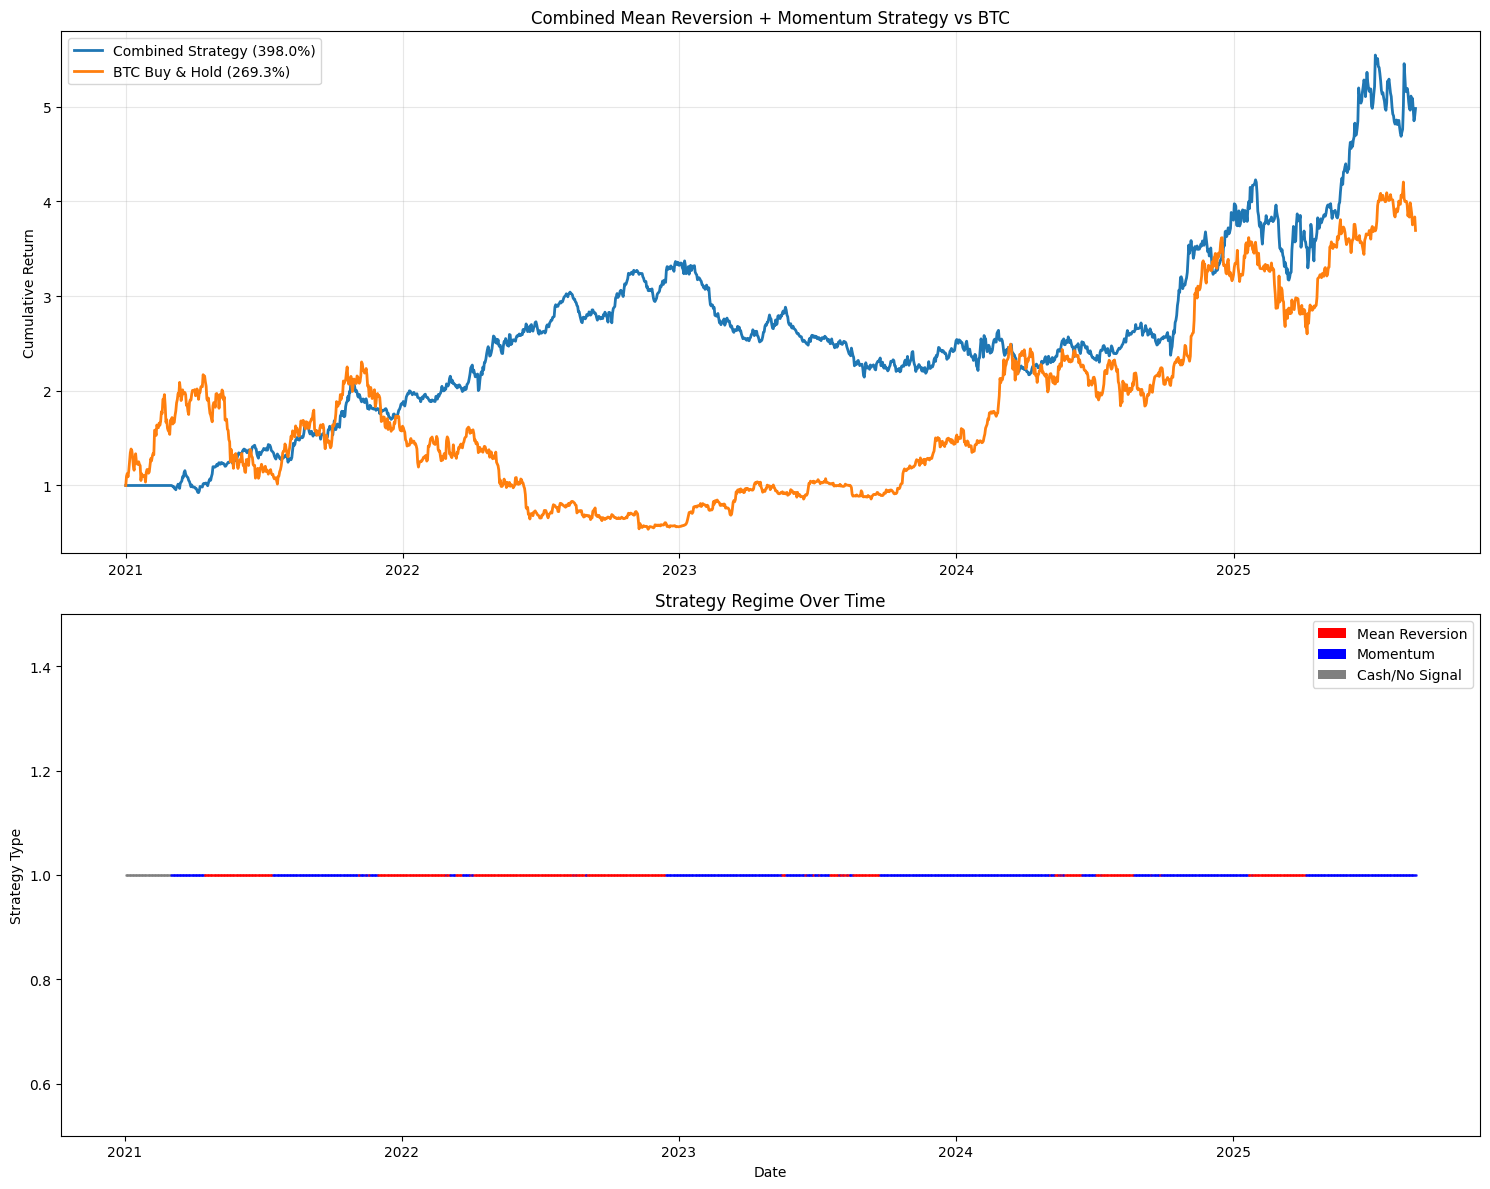

In [8]:
# Plot equity curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Combined strategy vs BTC
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_aligned = btc_cumret.reindex(equity_series.index)

ax1.plot(equity_series.index, equity_series, label=f'Combined Strategy ({total_return:.1f}%)', linewidth=2)
ax1.plot(equity_series.index, btc_aligned, label=f'BTC Buy & Hold ({(btc_aligned.iloc[-1]-1)*100:.1f}%)', linewidth=2)
ax1.set_title('Combined Mean Reversion + Momentum Strategy vs BTC')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Strategy regime visualization
strategy_colors = {'mean_reversion': 'red', 'momentum': 'blue', 'cash': 'gray', 'start': 'gray'}
for i, (date, strategy) in enumerate(zip(results_df.index, results_df['strategy'])):
    if i > 0:  # Skip first point
        ax2.scatter(date, 1, c=strategy_colors.get(strategy, 'black'), alpha=0.6, s=1)

ax2.set_title('Strategy Regime Over Time')
ax2.set_ylabel('Strategy Type')
ax2.set_xlabel('Date')
ax2.set_ylim(0.5, 1.5)

# Add legend for strategy colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Mean Reversion'),
                   Patch(facecolor='blue', label='Momentum'),
                   Patch(facecolor='gray', label='Cash/No Signal')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

In [9]:
# Analyze performance by strategy type
print("\n=== Performance by Strategy Type ===")

for strategy_name in ['mean_reversion', 'momentum']:
    strategy_mask = results_df['strategy'] == strategy_name
    strategy_periods = results_df[strategy_mask]
    
    if len(strategy_periods) > 1:
        strategy_returns = strategy_periods['equity'].pct_change().dropna()
        
        print(f"\n{strategy_name.upper()} Strategy:")
        print(f"  Active periods: {len(strategy_periods)} days")
        print(f"  Average daily return: {strategy_returns.mean() * 100:.3f}%")
        print(f"  Daily volatility: {strategy_returns.std() * 100:.3f}%")
        if strategy_returns.std() > 0:
            daily_sharpe = strategy_returns.mean() / strategy_returns.std()
            print(f"  Daily Sharpe: {daily_sharpe:.3f}")
        
        win_rate = (strategy_returns > 0).mean()
        print(f"  Win rate: {win_rate * 100:.1f}%")


=== Performance by Strategy Type ===

MEAN_REVERSION Strategy:
  Active periods: 676 days
  Average daily return: 0.231%
  Daily volatility: 3.335%
  Daily Sharpe: 0.069
  Win rate: 51.9%

MOMENTUM Strategy:
  Active periods: 965 days
  Average daily return: 0.197%
  Daily volatility: 2.527%
  Daily Sharpe: 0.078
  Win rate: 49.5%


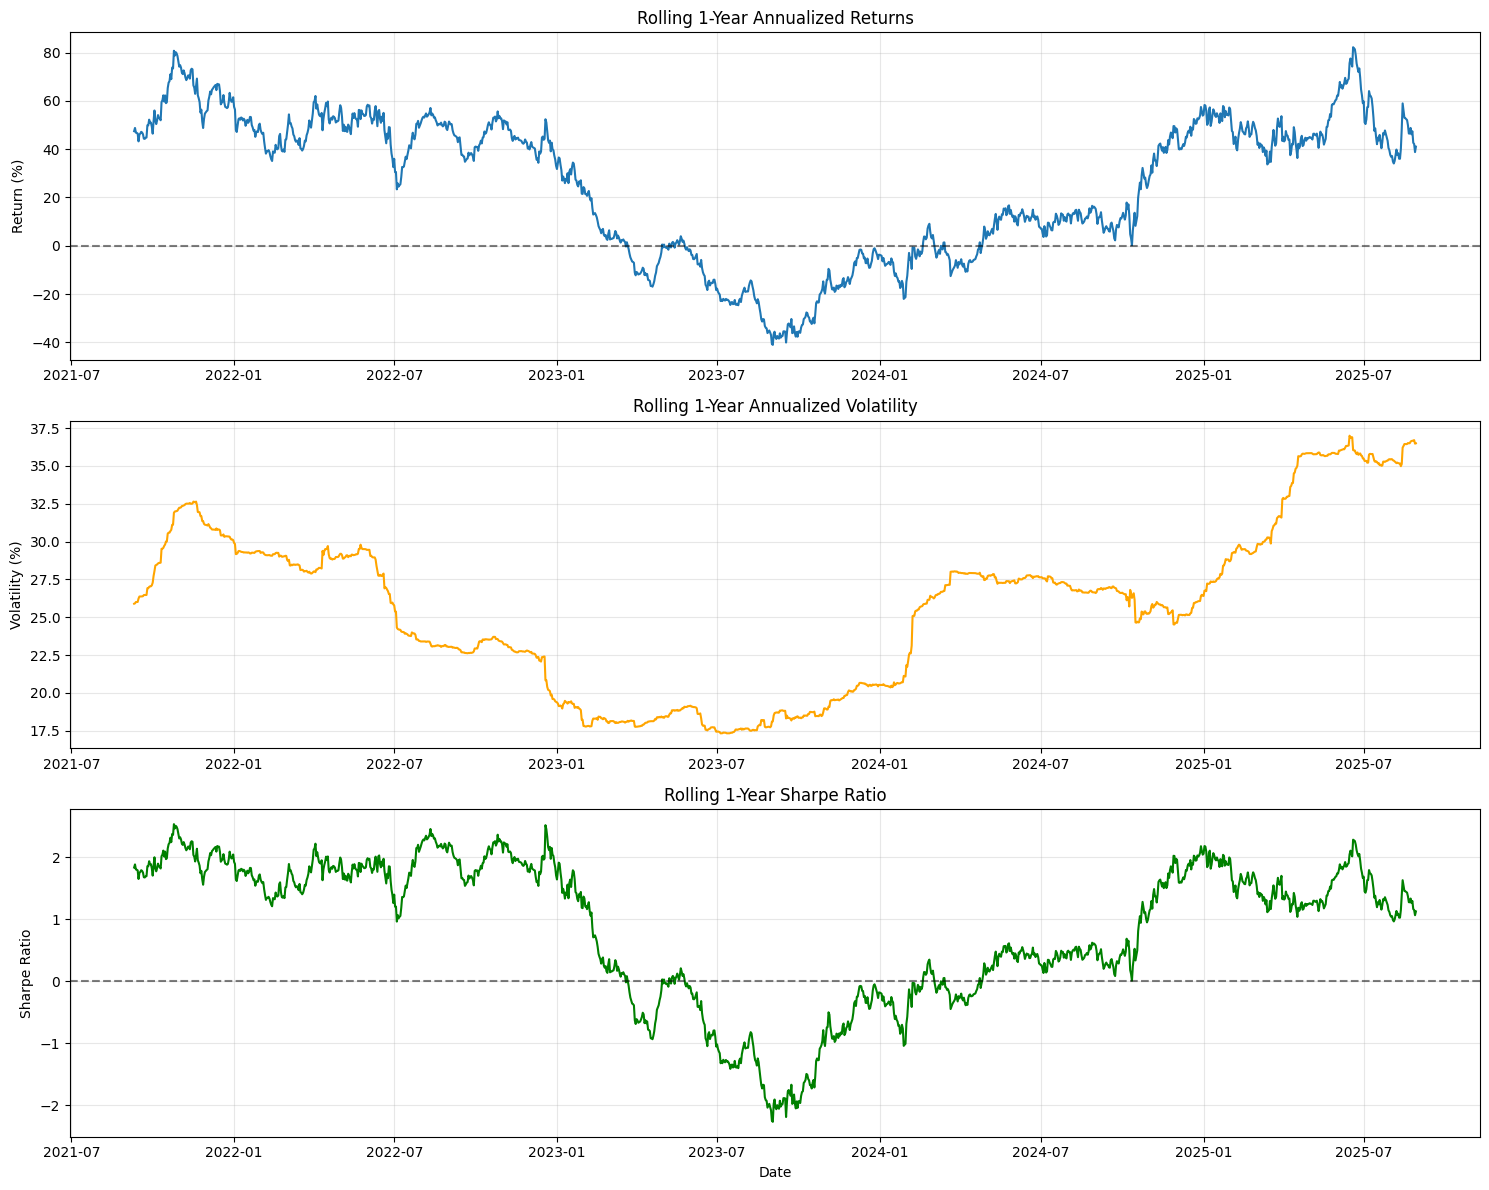

In [10]:
# Rolling performance analysis
window = 252  # 1 year rolling window
rolling_returns = equity_series.pct_change().rolling(window).mean() * 252
rolling_vol = equity_series.pct_change().rolling(window).std() * np.sqrt(252)
rolling_sharpe = rolling_returns / rolling_vol

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Rolling returns
ax1.plot(rolling_returns.index, rolling_returns * 100, label='Combined Strategy')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Rolling 1-Year Annualized Returns')
ax1.set_ylabel('Return (%)')
ax1.grid(True, alpha=0.3)

# Rolling volatility
ax2.plot(rolling_vol.index, rolling_vol * 100, label='Combined Strategy', color='orange')
ax2.set_title('Rolling 1-Year Annualized Volatility')
ax2.set_ylabel('Volatility (%)')
ax2.grid(True, alpha=0.3)

# Rolling Sharpe ratio
ax3.plot(rolling_sharpe.index, rolling_sharpe, label='Combined Strategy', color='green')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Rolling 1-Year Sharpe Ratio')
ax3.set_ylabel('Sharpe Ratio')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Information Coefficient (IC) Analysis
print("\n" + "="*60)
print("INFORMATION COEFFICIENT ANALYSIS")
print("="*60)

# Calculate forward returns for IC analysis
forward_returns_1d = price.pct_change().shift(-1)  # Next day returns
forward_returns_5d = price.pct_change(5).shift(-5)  # Next 5-day returns

# Prepare IC analysis function
def calculate_ic_stats(signal, forward_ret, signal_name, return_period):
    """Calculate IC statistics for a signal vs forward returns"""
    
    # Combine signal and forward returns, drop NaN
    combined = pd.DataFrame({
        'signal': signal.stack(),
        'forward_ret': forward_ret.stack()
    }).dropna()
    
    if len(combined) < 100:  # Need sufficient data
        return None
    
    # Calculate correlation (IC) for each date
    ic_series = []
    dates = []
    
    # Get unique dates from the stacked data
    all_dates = signal.index
    
    for date in all_dates:
        if date in signal.index and date in forward_ret.index:
            # Get cross-sectional data for this date
            signal_cross = signal.loc[date].dropna()
            fwd_ret_cross = forward_ret.loc[date].dropna()
            
            # Find common tickers
            common_tickers = signal_cross.index.intersection(fwd_ret_cross.index)
            
            if len(common_tickers) >= 10:  # Need at least 10 assets for correlation
                ic = signal_cross[common_tickers].corr(fwd_ret_cross[common_tickers])
                if not pd.isna(ic):
                    ic_series.append(ic)
                    dates.append(date)
    
    if len(ic_series) == 0:
        return None
        
    ic_series = pd.Series(ic_series, index=dates)
    
    # Calculate IC statistics
    ic_mean = ic_series.mean()
    ic_std = ic_series.std()
    ic_ir = ic_mean / ic_std if ic_std != 0 else np.nan
    ic_positive_pct = (ic_series > 0).mean() * 100
    
    return {
        'signal_name': signal_name,
        'return_period': return_period,
        'ic_mean': ic_mean,
        'ic_std': ic_std,
        'ic_ir': ic_ir,
        'ic_positive_pct': ic_positive_pct,
        'ic_series': ic_series,
        'num_observations': len(ic_series)
    }

# Calculate IC for both strategies
print("Calculating Information Coefficients...")

# Mean Reversion IC (expect negative IC since we inverse the signal)
mr_ic_1d = calculate_ic_stats(mean_rev_returns, forward_returns_1d, 
                              "Mean Reversion (30d)", "1-day")
mr_ic_5d = calculate_ic_stats(mean_rev_returns, forward_returns_5d, 
                              "Mean Reversion (30d)", "5-day")

# Momentum IC (expect positive IC)
mom_ic_1d = calculate_ic_stats(momentum_returns, forward_returns_1d, 
                               "Momentum (14d)", "1-day")
mom_ic_5d = calculate_ic_stats(momentum_returns, forward_returns_5d, 
                               "Momentum (14d)", "5-day")

# Display results
ic_results = [mr_ic_1d, mr_ic_5d, mom_ic_1d, mom_ic_5d]
ic_results = [r for r in ic_results if r is not None]

print(f"\n{'Strategy':<20} {'Period':<8} {'IC Mean':<10} {'IC Std':<10} {'IC IR':<10} {'% Positive':<12} {'Obs':<6}")
print("-" * 80)

for result in ic_results:
    print(f"{result['signal_name']:<20} {result['return_period']:<8} "
          f"{result['ic_mean']:<10.4f} {result['ic_std']:<10.4f} "
          f"{result['ic_ir']:<10.3f} {result['ic_positive_pct']:<12.1f} "
          f"{result['num_observations']:<6}")

# Interpretation
print(f"\nIC Interpretation:")
print(f"• IC > 0: Signal positively predicts returns (good for momentum)")
print(f"• IC < 0: Signal negatively predicts returns (good for mean reversion)")
print(f"• |IC| > 0.05: Generally considered significant")
print(f"• IC IR > 0.5: Good signal quality")
print(f"• % Positive: Consistency of signal direction")


INFORMATION COEFFICIENT ANALYSIS


C:\Users\USER\AppData\Local\Temp\ipykernel_18336\743640559.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns_1d = price.pct_change().shift(-1)  # Next day returns
C:\Users\USER\AppData\Local\Temp\ipykernel_18336\743640559.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  forward_returns_5d = price.pct_change(5).shift(-5)  # Next 5-day returns


Calculating Information Coefficients...

Strategy             Period   IC Mean    IC Std     IC IR      % Positive   Obs   
--------------------------------------------------------------------------------
Mean Reversion (30d) 1-day    -0.0037    0.2066     -0.018     46.6         1701  
Mean Reversion (30d) 5-day    -0.0006    0.1988     -0.003     45.7         1697  
Momentum (14d)       1-day    -0.0029    0.2092     -0.014     47.1         1716  
Momentum (14d)       5-day    -0.0075    0.1935     -0.039     45.3         1712  

IC Interpretation:
• IC > 0: Signal positively predicts returns (good for momentum)
• IC < 0: Signal negatively predicts returns (good for mean reversion)
• |IC| > 0.05: Generally considered significant
• IC IR > 0.5: Good signal quality
• % Positive: Consistency of signal direction



IC TIME SERIES ANALYSIS


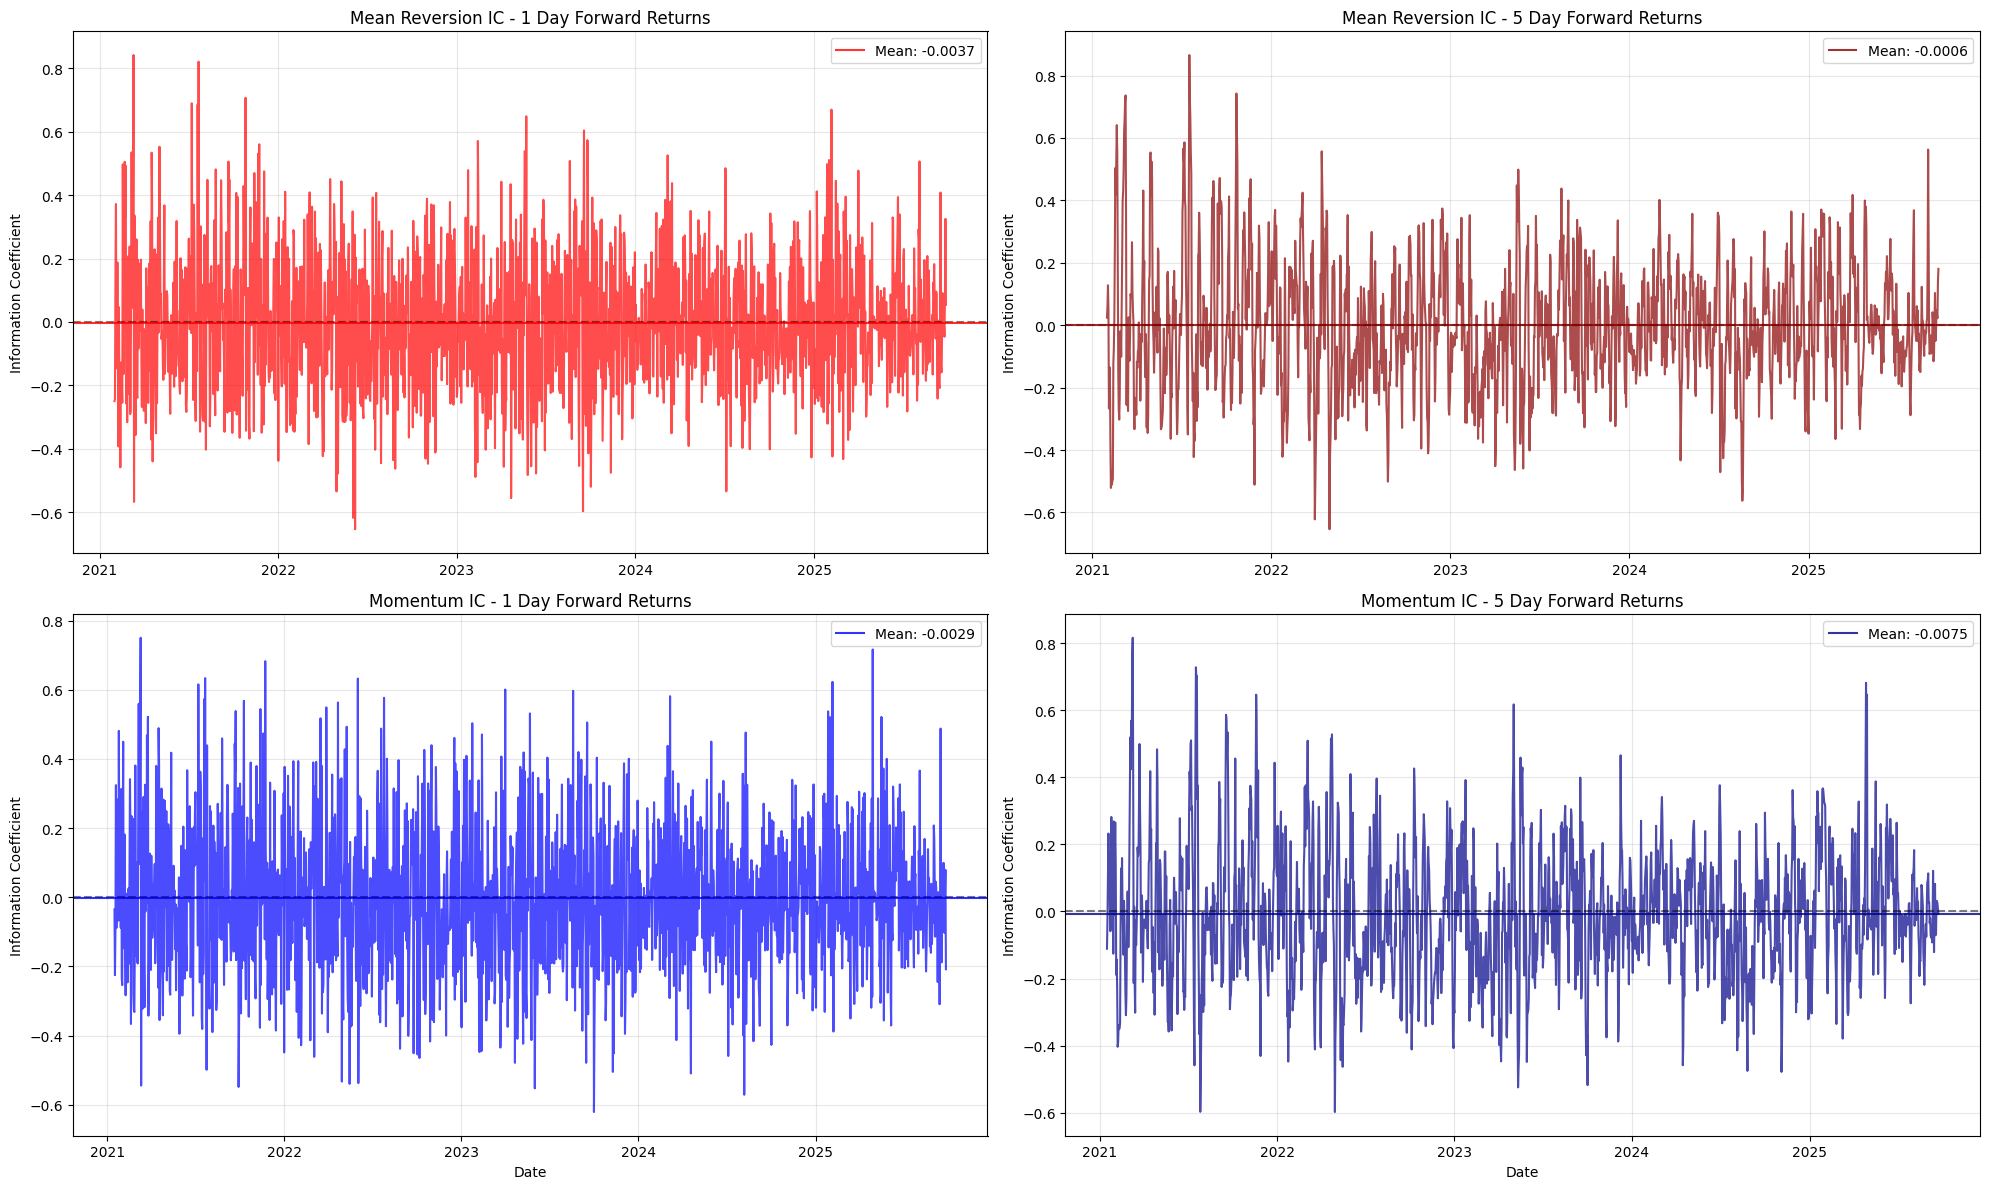


Rolling IC Analysis (252-day window):

Mean Reversion (30d) - 1-day:
  Rolling IC Mean Range: -0.0325 to 0.0248
  Rolling IC Std Range: 0.1667 to 0.2464
  IC Stability Score: 4.878

Mean Reversion (30d) - 5-day:
  Rolling IC Mean Range: -0.0470 to 0.0647
  Rolling IC Std Range: 0.1358 to 0.2744
  IC Stability Score: 5.263

Momentum (14d) - 1-day:
  Rolling IC Mean Range: -0.0240 to 0.0213
  Rolling IC Std Range: 0.1751 to 0.2398
  IC Stability Score: 4.780

Momentum (14d) - 5-day:
  Rolling IC Mean Range: -0.0601 to 0.0362
  Rolling IC Std Range: 0.1349 to 0.2475
  IC Stability Score: 5.265


In [12]:
# IC Time Series Analysis and Visualization
print(f"\n{'='*60}")
print("IC TIME SERIES ANALYSIS")
print("="*60)

# Plot IC time series
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Mean Reversion IC plots
if mr_ic_1d and len(mr_ic_1d['ic_series']) > 0:
    ax1.plot(mr_ic_1d['ic_series'].index, mr_ic_1d['ic_series'], alpha=0.7, color='red')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.axhline(y=mr_ic_1d['ic_mean'], color='red', linestyle='-', alpha=0.8, 
                label=f"Mean: {mr_ic_1d['ic_mean']:.4f}")
    ax1.set_title('Mean Reversion IC - 1 Day Forward Returns')
    ax1.set_ylabel('Information Coefficient')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

if mr_ic_5d and len(mr_ic_5d['ic_series']) > 0:
    ax2.plot(mr_ic_5d['ic_series'].index, mr_ic_5d['ic_series'], alpha=0.7, color='darkred')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.axhline(y=mr_ic_5d['ic_mean'], color='darkred', linestyle='-', alpha=0.8,
                label=f"Mean: {mr_ic_5d['ic_mean']:.4f}")
    ax2.set_title('Mean Reversion IC - 5 Day Forward Returns')
    ax2.set_ylabel('Information Coefficient')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Momentum IC plots
if mom_ic_1d and len(mom_ic_1d['ic_series']) > 0:
    ax3.plot(mom_ic_1d['ic_series'].index, mom_ic_1d['ic_series'], alpha=0.7, color='blue')
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.axhline(y=mom_ic_1d['ic_mean'], color='blue', linestyle='-', alpha=0.8,
                label=f"Mean: {mom_ic_1d['ic_mean']:.4f}")
    ax3.set_title('Momentum IC - 1 Day Forward Returns')
    ax3.set_ylabel('Information Coefficient')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

if mom_ic_5d and len(mom_ic_5d['ic_series']) > 0:
    ax4.plot(mom_ic_5d['ic_series'].index, mom_ic_5d['ic_series'], alpha=0.7, color='darkblue')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.axhline(y=mom_ic_5d['ic_mean'], color='darkblue', linestyle='-', alpha=0.8,
                label=f"Mean: {mom_ic_5d['ic_mean']:.4f}")
    ax4.set_title('Momentum IC - 5 Day Forward Returns')
    ax4.set_ylabel('Information Coefficient')
    ax4.set_xlabel('Date')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Rolling IC analysis
window_ic = 252  # 1 year rolling window
print(f"\nRolling IC Analysis (252-day window):")

for result in ic_results:
    if result and len(result['ic_series']) > window_ic:
        rolling_ic_mean = result['ic_series'].rolling(window_ic).mean()
        rolling_ic_std = result['ic_series'].rolling(window_ic).std()
        
        print(f"\n{result['signal_name']} - {result['return_period']}:")
        print(f"  Rolling IC Mean Range: {rolling_ic_mean.min():.4f} to {rolling_ic_mean.max():.4f}")
        print(f"  Rolling IC Std Range: {rolling_ic_std.min():.4f} to {rolling_ic_std.max():.4f}")
        
        # IC stability (lower std of IC means more stable signal)
        ic_stability = 1 / rolling_ic_std.mean() if rolling_ic_std.mean() > 0 else 0
        print(f"  IC Stability Score: {ic_stability:.3f}")

In [13]:
# Signal Strength by Market Regime Analysis
print(f"\n{'='*60}")
print("IC ANALYSIS BY MARKET REGIME")
print("="*60)

def calculate_regime_ic(signal_returns, forward_returns, btc_filter, regime_name, signal_name):
    """Calculate IC for specific market regime"""
    
    regime_ic_series = []
    regime_dates = []
    
    for date in signal_returns.index:
        if date in btc_filter.index and date in forward_returns.index:
            # Check if we're in the specified regime
            if regime_name == 'bull' and btc_filter.loc[date] >= 0:
                use_date = True
            elif regime_name == 'bear' and btc_filter.loc[date] < 0:
                use_date = True
            else:
                use_date = False
                
            if use_date:
                signal_cross = signal_returns.loc[date].dropna()
                fwd_ret_cross = forward_returns.loc[date].dropna()
                
                common_tickers = signal_cross.index.intersection(fwd_ret_cross.index)
                
                if len(common_tickers) >= 10:
                    ic = signal_cross[common_tickers].corr(fwd_ret_cross[common_tickers])
                    if not pd.isna(ic):
                        regime_ic_series.append(ic)
                        regime_dates.append(date)
    
    if len(regime_ic_series) == 0:
        return None
        
    regime_ic_series = pd.Series(regime_ic_series, index=regime_dates)
    
    return {
        'regime': regime_name,
        'signal_name': signal_name,
        'ic_mean': regime_ic_series.mean(),
        'ic_std': regime_ic_series.std(),
        'ic_ir': regime_ic_series.mean() / regime_ic_series.std() if regime_ic_series.std() > 0 else np.nan,
        'ic_positive_pct': (regime_ic_series > 0).mean() * 100,
        'num_observations': len(regime_ic_series),
        'ic_series': regime_ic_series
    }

# Calculate regime-specific ICs
regime_results = []

# Mean Reversion in different regimes
mr_bull_1d = calculate_regime_ic(mean_rev_returns, forward_returns_1d, btc_90d_return, 
                                'bull', 'Mean Reversion (30d) - Bull Market')
mr_bear_1d = calculate_regime_ic(mean_rev_returns, forward_returns_1d, btc_90d_return, 
                                'bear', 'Mean Reversion (30d) - Bear Market')

# Momentum in different regimes  
mom_bull_1d = calculate_regime_ic(momentum_returns, forward_returns_1d, btc_90d_return,
                                 'bull', 'Momentum (14d) - Bull Market')
mom_bear_1d = calculate_regime_ic(momentum_returns, forward_returns_1d, btc_90d_return,
                                 'bear', 'Momentum (14d) - Bear Market')

regime_results = [mr_bull_1d, mr_bear_1d, mom_bull_1d, mom_bear_1d]
regime_results = [r for r in regime_results if r is not None]

print(f"\\n{'Strategy & Regime':<35} {'IC Mean':<10} {'IC Std':<10} {'IC IR':<10} {'% Positive':<12} {'Obs':<6}")
print("-" * 90)

for result in regime_results:
    print(f"{result['signal_name']:<35} {result['ic_mean']:<10.4f} {result['ic_std']:<10.4f} "
          f"{result['ic_ir']:<10.3f} {result['ic_positive_pct']:<12.1f} "
          f"{result['num_observations']:<6}")

# Key insights
print(f"\\nKey Insights:")
if mr_bear_1d and mr_bull_1d:
    mr_bear_ic = mr_bear_1d['ic_mean']
    mr_bull_ic = mr_bull_1d['ic_mean']
    print(f"• Mean Reversion works {'better' if abs(mr_bear_ic) > abs(mr_bull_ic) else 'worse'} in bear markets: "
          f"Bear IC = {mr_bear_ic:.4f}, Bull IC = {mr_bull_ic:.4f}")

if mom_bull_1d and mom_bear_1d:
    mom_bull_ic = mom_bull_1d['ic_mean']
    mom_bear_ic = mom_bear_1d['ic_mean']
    print(f"• Momentum works {'better' if mom_bull_ic > mom_bear_ic else 'worse'} in bull markets: "
          f"Bull IC = {mom_bull_ic:.4f}, Bear IC = {mom_bear_ic:.4f}")

# Strategy effectiveness in intended regimes
if mr_bear_1d:
    mr_effectiveness = abs(mr_bear_1d['ic_mean']) > 0.02  # Threshold for meaningful IC
    print(f"• Mean Reversion strategy in bear markets: {'Effective' if mr_effectiveness else 'Weak'} "
          f"(|IC| = {abs(mr_bear_1d['ic_mean']):.4f})")

if mom_bull_1d:
    mom_effectiveness = mom_bull_1d['ic_mean'] > 0.02  # Positive IC for momentum
    print(f"• Momentum strategy in bull markets: {'Effective' if mom_effectiveness else 'Weak'} "
          f"(IC = {mom_bull_1d['ic_mean']:.4f})")


IC ANALYSIS BY MARKET REGIME
\nStrategy & Regime                   IC Mean    IC Std     IC IR      % Positive   Obs   
------------------------------------------------------------------------------------------
Mean Reversion (30d) - Bull Market  0.0012     0.1985     0.006      46.1         965   
Mean Reversion (30d) - Bear Market  -0.0112    0.2094     -0.054     47.3         676   
Momentum (14d) - Bull Market        0.0015     0.1985     0.008      47.3         965   
Momentum (14d) - Bear Market        -0.0128    0.2172     -0.059     46.3         676   
\nKey Insights:
• Mean Reversion works better in bear markets: Bear IC = -0.0112, Bull IC = 0.0012
• Momentum works better in bull markets: Bull IC = 0.0015, Bear IC = -0.0128
• Mean Reversion strategy in bear markets: Weak (|IC| = 0.0112)
• Momentum strategy in bull markets: Weak (IC = 0.0015)
